# Keras ile Data Augmentation, Transfer Learning ve Fine Tuning



Colabda çalışıyorken hızlı eğitim için ÇAlışma zamanı türünü GPU ya değiştirebilirsiniz.


## Gerekli Kütüphanelerin Yüklenmesi

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
import matplotlib.pyplot as plt
import numpy as np

# TensorFlow sürümünü kontrol etme
print(f"TensorFlow sürümü: {tf.__version__}")

TensorFlow sürümü: 2.18.0


## Veri Setinin Yüklenmesi

CIFAR-10 veri seti, 10 farklı sınıfa ait 60,000 renkli görüntü içerir (50,000 eğitim, 10,000 test). Her görüntü 32x32 piksel boyutundadır.

In [10]:
def load_cifar10():
    print("CIFAR-10 veri seti yükleniyor...")
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    # Piksel değerlerini 0-1 arasına normalize etme
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # One-hot encoding
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    print(f"Veri seti yüklendi: {x_train.shape[0]} eğitim, {x_test.shape[0]} test örneği")
    print(f"Görüntü boyutu: {x_train.shape[1:]}")
    return (x_train, y_train), (x_test, y_test)

# Veri setini yükleme
(x_train, y_train), (x_test, y_test) = load_cifar10()

CIFAR-10 veri seti yükleniyor...
Veri seti yüklendi: 50000 eğitim, 10000 test örneği
Görüntü boyutu: (32, 32, 3)


## Veri Setini Görselleştirme

Veri setindeki bazı örnek görüntüleri inceleyelim.

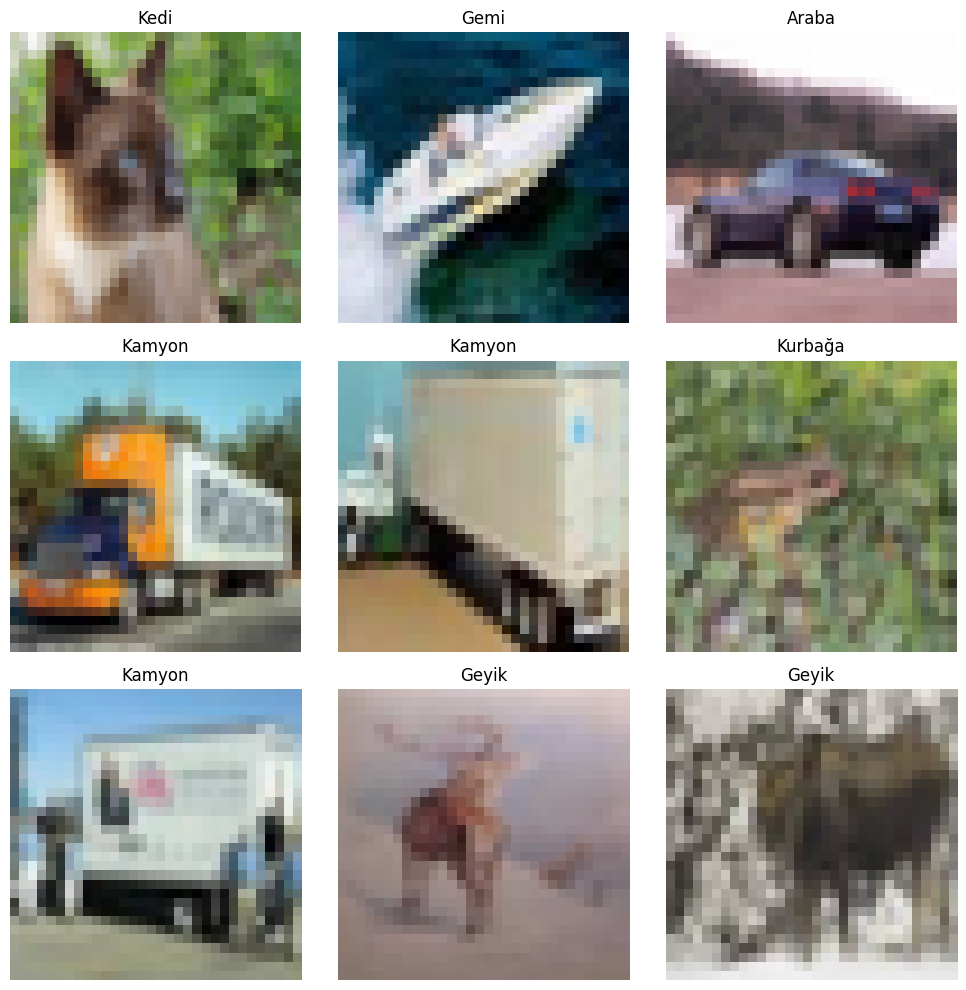

In [11]:
# CIFAR-10 sınıf isimleri
class_names = ['Uçak', 'Araba', 'Kuş', 'Kedi', 'Geyik', 'Köpek', 'Kurbağa', 'At', 'Gemi', 'Kamyon']

# Rastgele 9 görüntüyü görselleştirme
plt.figure(figsize=(10, 10))
for i in range(9):
    idx = np.random.randint(0, x_train.shape[0])
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[idx])
    plt.title(class_names[np.argmax(y_train[idx])])
    plt.axis('off')
plt.tight_layout()

# 1. Data Augmentation (Veri Artırma)

Veri artırma, mevcut eğitim verilerini çeşitli dönüşümlerle (döndürme, kaydırma, çevirme vb.) çoğaltarak modelin genelleme yeteneğini artırmaya yardımcı olur. Bu, özellikle sınırlı veri setlerinde aşırı öğrenmeyi (overfitting) azaltmak için etkilidir.

## 1.1 Temel Veri Artırma

In [12]:
def basic_data_augmentation():
    # Veri artırma için ImageDataGenerator oluşturma
    datagen = ImageDataGenerator(
        rotation_range=15,      # Rastgele 15 dereceye kadar döndürme
        width_shift_range=0.1,  # Genişliğin %10'u kadar kaydırma
        height_shift_range=0.1, # Yüksekliğin %10'u kadar kaydırma
        horizontal_flip=True,   # Yatay çevirme
        zoom_range=0.1          # %10'a kadar yakınlaştırma/uzaklaştırma
    )

    return datagen

# Veri artırma generator'ı oluşturma
datagen = basic_data_augmentation()

## 1.2 Artırılmış Görüntüleri Görselleştirme

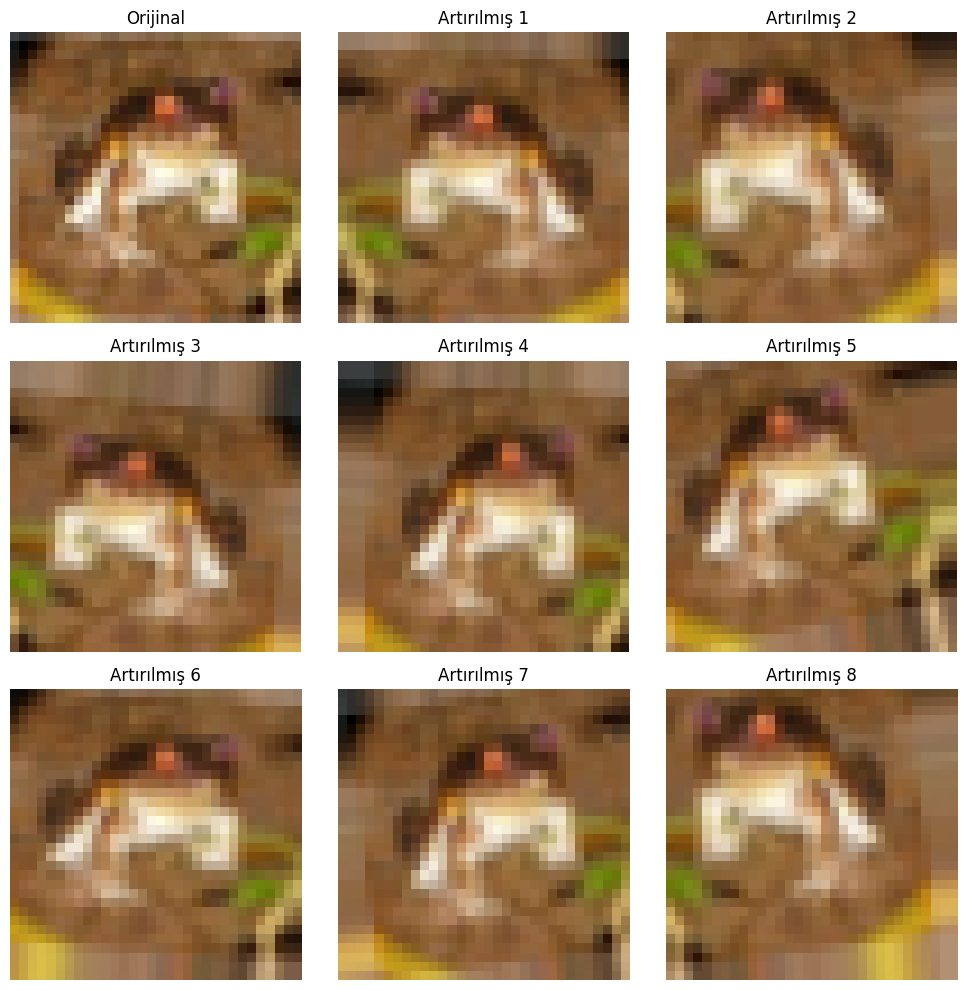

In [5]:
# Görselleştirme için bir görüntü seçme
img = x_train[0]  # İlk görüntüyü seçiyoruz
img = img.reshape((1,) + img.shape)  # (1, height, width, channels) şekline getirme

# Artırılmış görüntüleri oluşturma ve görselleştirme
plt.figure(figsize=(10, 10))

# Orijinal görüntü
plt.subplot(3, 3, 1)
plt.imshow(x_train[0])
plt.title('Orijinal')
plt.axis('off')

# Artırılmış görüntüler
i = 2
for batch in datagen.flow(img, batch_size=1):
    plt.subplot(3, 3, i)
    plt.imshow(batch[0])
    plt.title(f'Artırılmış {i-1}')
    plt.axis('off')
    i += 1
    if i > 9:
        break

plt.tight_layout()

## 1.3 Gelişmiş Veri Artırma Teknikleri

In [6]:
def advanced_data_augmentation():
    # Daha fazla veri artırma seçeneği içeren generator
    datagen = ImageDataGenerator(
        rotation_range=20,        # Rastgele 20 dereceye kadar döndürme
        width_shift_range=0.2,    # Genişliğin %20'si kadar kaydırma
        height_shift_range=0.2,   # Yüksekliğin %20'si kadar kaydırma
        shear_range=0.15,         # Kesme dönüşümü
        zoom_range=0.15,          # Yakınlaştırma/uzaklaştırma
        horizontal_flip=True,     # Yatay çevirme
        fill_mode='nearest',      # Boşlukları doldurma yöntemi
        brightness_range=[0.8, 1.2]  # Parlaklık ayarı
    )

    return datagen

# Gelişmiş veri artırma generator'ı oluşturma
advanced_datagen = advanced_data_augmentation()

## 1.4 Veri Artırma ile Model Eğitimi

Basit bir CNN modeli oluşturup veri artırma ile eğitelim.

In [13]:
def train_with_augmentation(x_train, y_train, epochs=5, batch_size=32):
    # Veri artırma için generator oluşturma
    datagen = basic_data_augmentation()

    # Basit bir CNN modeli oluşturma
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    # Modeli derleme
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Model özeti
    model.summary()

    # Veri artırma ile eğitim
    print("Veri artırma ile model eğitimi başlıyor...")
    datagen.fit(x_train)

    # Eğitim için daha küçük bir alt küme kullanma (hızlı örnek için)
    sample_size = 5000
    x_train_sample = x_train[:sample_size]
    y_train_sample = y_train[:sample_size]

    history = model.fit(
        datagen.flow(x_train_sample, y_train_sample, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_test, y_test),
        steps_per_epoch=len(x_train_sample) // batch_size
    )

    return model, history


model, history = train_with_augmentation(x_train, y_train, epochs=3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

Veri artırma ile model eğitimi başlıyor...
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


156/156 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.1634 - loss: 2.1836 - val_accuracy: 0.3103 - val_loss: 1.8230
Epoch 2/3
  1/156 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4062 - loss: 1.6032

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4062 - loss: 1.6032 - val_accuracy: 0.3152 - val_loss: 1.8303
Epoch 3/3
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.3207 - loss: 1.8334 - val_accuracy: 0.3519 - val_loss: 1.7581


# 2. Transfer Learning (Transfer Öğrenme)

Transfer learning, önceden eğitilmiş bir modeli (genellikle büyük bir veri seti üzerinde eğitilmiş) alıp, kendi özel görevimiz için uyarlamayı içerir. Bu, sınırlı veri veya hesaplama kaynakları ile daha iyi sonuçlar elde etmemizi sağlar.

## 2.1 MobileNetV2 ile Transfer Learning

In [14]:
def mobilenet_transfer_learning(input_shape=(32, 32, 3), num_classes=10):
    # MobileNetV2 modelini yükleme (weights='imagenet' ile önceden eğitilmiş ağırlıklar kullanılır)
    # include_top=False ile sınıflandırma katmanları hariç tutulur
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Önceden eğitilmiş katmanları dondurma (eğitim sırasında güncellenmeyecek)
    base_model.trainable = False

    # Yeni sınıflandırma katmanları ekleme
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Modeli derleme
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("MobileNetV2 transfer learning modeli oluşturuldu.")
    return model

# MobileNetV2 transfer learning modeli oluşturma
mobilenet_model = mobilenet_transfer_learning()

<ipython-input-14-de321bd25911>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV2 transfer learning modeli oluşturuldu.


## 2.2 EfficientNetB0 ile Transfer Learning

EfficientNet, daha az parametre ile daha iyi performans sağlayan modern bir model ailesidir.

In [15]:
def efficientnet_transfer_learning(input_shape=(32, 32, 3), num_classes=10):
    # EfficientNetB0 modelini yükleme (daha küçük bir model)
    base_model = EfficientNetB0(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Önceden eğitilmiş katmanları dondurma
    base_model.trainable = False

    # Yeni sınıflandırma katmanları ekleme
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Modeli derleme
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("EfficientNetB0 transfer learning modeli oluşturuldu.")
    return model

# EfficientNetB0 transfer learning modeli oluşturma
efficientnet_model = efficientnet_transfer_learning()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
EfficientNetB0 transfer learning modeli oluşturuldu.


## 2.3 Transfer Learning ile Model Eğitimi

In [16]:
def train_transfer_learning_model(model, x_train, y_train, x_test, y_test, epochs=5, batch_size=32):
    # Veri artırma için generator oluşturma
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1
    )

    # Eğitim için daha küçük bir alt küme kullanma (hızlı örnek için)
    sample_size = 5000
    x_train_sample = x_train[:sample_size]
    y_train_sample = y_train[:sample_size]

    # Veri artırma ile eğitim
    print("Transfer learning modeli eğitimi başlıyor...")
    datagen.fit(x_train_sample)
    history = model.fit(
        datagen.flow(x_train_sample, y_train_sample, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_test, y_test),
        steps_per_epoch=len(x_train_sample) // batch_size
    )

    # Test seti üzerinde değerlendirme
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(f"Test doğruluğu: {test_acc:.4f}")

    return history


history = train_transfer_learning_model(mobilenet_model, x_train, y_train, x_test, y_test, epochs=3)

## 2.4 Eğitim Geçmişini Görselleştirme

In [17]:
def visualize_training_history(history):
    # Eğitim ve doğrulama doğruluğunu görselleştirme
    plt.figure(figsize=(12, 4))

    # Doğruluk grafiği
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
    plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
    plt.title('Model Doğruluğu')
    plt.xlabel('Epoch')
    plt.ylabel('Doğruluk')
    plt.legend()

    # Kayıp grafiği
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.title('Model Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()

    plt.tight_layout()

# Eğitim geçmişini görselleştirmek için önce modeli eğitmeniz gerekir
# visualize_training_history(history)

# 3. Fine Tuning (İnce Ayar)
Bundan sonraki konulardan sorumlu değilsiniz . ilgili öğrenciler için konunun devamı olduğu için verilmiştir

Fine tuning, transfer learning'in bir adım ötesidir. Önceden eğitilmiş modelin bazı katmanlarını (genellikle son birkaç katmanı) yeniden eğiterek, modeli özel görevimize daha iyi uyarlarız.

## 3.1 MobileNetV2 ile Fine Tuning

In [ ]:
def mobilenet_fine_tuning(input_shape=(32, 32, 3), num_classes=10):
    # MobileNetV2 modelini yükleme
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Önce tüm katmanları dondurma
    base_model.trainable = False

    # Modeli oluşturma
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Modeli derleme
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("MobileNetV2 modeli oluşturuldu.")
    return model, base_model

# MobileNetV2 fine tuning modeli oluşturma
model, base_model = mobilenet_fine_tuning()

## 3.2 İki Aşamalı Eğitim (Transfer Learning + Fine Tuning)

In [ ]:
def two_stage_training(model, base_model, x_train, y_train, x_test, y_test):
    # Veri artırma için generator oluşturma
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1
    )

    # Eğitim için daha küçük bir alt küme kullanma (hızlı örnek için)
    sample_size = 5000
    x_train_sample = x_train[:sample_size]
    y_train_sample = y_train[:sample_size]

    # 1. Aşama: Sadece yeni eklenen katmanları eğitme (Transfer Learning)
    print("Aşama 1: Transfer Learning - Sadece yeni katmanlar eğitiliyor...")
    datagen.fit(x_train_sample)
    history1 = model.fit(
        datagen.flow(x_train_sample, y_train_sample, batch_size=32),
        epochs=3,
        validation_data=(x_test, y_test),
        steps_per_epoch=len(x_train_sample) // 32
    )

    # 2. Aşama: Fine Tuning - Bazı önceden eğitilmiş katmanları da eğitme
    print("Aşama 2: Fine Tuning - Son katmanlar açılıyor...")

    # Son birkaç katmanı eğitim için açma
    # MobileNetV2'nin son bloğunu açıyoruz (son 10 katman)
    fine_tune_at = len(base_model.layers) - 10

    # Belirtilen katmana kadar dondurma, sonrasını eğitime açma
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Daha düşük öğrenme oranı ile yeniden derleme
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),  # Daha düşük öğrenme oranı
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fine tuning eğitimi
    print("Fine tuning eğitimi başlıyor...")
    history2 = model.fit(
        datagen.flow(x_train_sample, y_train_sample, batch_size=32),
        epochs=5,
        validation_data=(x_test, y_test),
        steps_per_epoch=len(x_train_sample) // 32
    )

    return history1, history2

# Eğitimi çalıştırmak için yorum işaretini kaldırın
# history1, history2 = two_stage_training(model, base_model, x_train, y_train, x_test, y_test)

## 3.3 Katman Dondurma Stratejileri

Fine tuning sırasında hangi katmanların dondurulacağı, modelin performansını önemli ölçüde etkiler.

In [ ]:
def layer_freezing_strategies(input_shape=(32, 32, 3), num_classes=10):
    # MobileNetV2 modelini yükleme
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Strateji 1: Tüm katmanları dondurma (Transfer Learning)
    def strategy_1():
        base_model.trainable = False
        return "Tüm katmanlar donduruldu (Transfer Learning)"

    # Strateji 2: Son bloğu açma (Hafif Fine Tuning)
    def strategy_2():
        base_model.trainable = True
        for layer in base_model.layers[:-10]:  # Son 10 katman hariç dondurma
            layer.trainable = False
        return "Son blok açıldı (Hafif Fine Tuning)"

    # Strateji 3: Son birkaç bloğu açma (Orta Fine Tuning)
    def strategy_3():
        base_model.trainable = True
        for layer in base_model.layers[:-30]:  # Son 30 katman hariç dondurma
            layer.trainable = False
        return "Son birkaç blok açıldı (Orta Fine Tuning)"

    # Strateji 4: Tüm katmanları açma (Tam Fine Tuning)
    def strategy_4():
        base_model.trainable = True
        return "Tüm katmanlar açıldı (Tam Fine Tuning)"

    strategies = [strategy_1, strategy_2, strategy_3, strategy_4]

    print("Fine Tuning Stratejileri:")
    for i, strategy in enumerate(strategies, 1):
        print(f"Strateji {i}: {strategy()}")
        # Eğitilebilir parametre sayısını gösterme
        trainable_params = sum([np.prod(layer.trainable_weights[0].shape)
                              for layer in base_model.layers
                              if layer.trainable and len(layer.trainable_weights) > 0])
        print(f"  Eğitilebilir parametre sayısı: {trainable_params:,}")

    return base_model

# Katman dondurma stratejilerini gösterme
layer_freezing_strategies()

## 3.4 İki Aşamalı Eğitim Geçmişini Görselleştirme

In [ ]:
def visualize_two_stage_training(history1, history2):
    # İki aşamalı eğitim geçmişini birleştirme
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    # Transfer learning ve fine tuning arasındaki sınırı belirleme
    boundary_epoch = len(history1.history['accuracy'])
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    # Doğruluk grafiği
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Eğitim Doğruluğu')
    plt.plot(epochs, val_acc, 'r', label='Doğrulama Doğruluğu')
    plt.axvline(x=boundary_epoch, color='g', linestyle='--',
                label='Fine Tuning Başlangıcı')
    plt.title('Model Doğruluğu')
    plt.xlabel('Epoch')
    plt.ylabel('Doğruluk')
    plt.legend()

    # Kayıp grafiği
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Eğitim Kaybı')
    plt.plot(epochs, val_loss, 'r', label='Doğrulama Kaybı')
    plt.axvline(x=boundary_epoch, color='g', linestyle='--',
                label='Fine Tuning Başlangıcı')
    plt.title('Model Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()

    plt.tight_layout()

# İki aşamalı eğitim geçmişini görselleştirmek için önce modeli eğitmeniz gerekir
# visualize_two_stage_training(history1, history2)

# Özet ve Karşılaştırma

Bu notebook'ta üç önemli tekniği inceledik:

1. **Data Augmentation (Veri Artırma)**: Mevcut veri setini çeşitli dönüşümlerle zenginleştirerek modelin genelleme yeteneğini artırır. Özellikle küçük veri setlerinde aşırı öğrenmeyi azaltmak için etkilidir.

2. **Transfer Learning (Transfer Öğrenme)**: Önceden eğitilmiş bir modeli alıp, kendi görevimiz için uyarlarız. Önceden eğitilmiş katmanlar dondurulur ve sadece yeni eklenen katmanlar eğitilir. Bu, sınırlı veri veya hesaplama kaynakları ile daha iyi sonuçlar elde etmemizi sağlar.

3. **Fine Tuning (İnce Ayar)**: Transfer learning'in bir adım ötesidir. Önceden eğitilmiş modelin bazı katmanlarını (genellikle son birkaç katmanı) yeniden eğiterek, modeli özel görevimize daha iyi uyarlarız. Daha fazla veri ve hesaplama kaynağı gerektirir, ancak genellikle daha iyi sonuçlar verir.

## Hangi Teknik Ne Zaman Kullanılmalı?

- **Sadece Data Augmentation**: Veri setiniz küçükse ve sıfırdan bir model eğitmek istiyorsanız.
- **Transfer Learning**: Veri setiniz küçük veya orta boyutta ve hesaplama kaynaklarınız sınırlıysa.
- **Fine Tuning**: Veri setiniz yeterince büyük ve hesaplama kaynaklarınız varsa, en iyi sonuçları elde etmek için.

Pratikte, bu teknikleri birleştirmek genellikle en iyi sonuçları verir: Veri artırma + Transfer learning + Fine tuning.